In [1]:
## basic modules
import os
import sys
import re
import xarray as xr
import glob
import numpy as np
import pandas as pd
import itertools ## need this for the cbarticks
import textwrap
import datetime
import shutil
import subprocess

## plotting modules
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import cmocean
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## personal modules
sys.path.append('../cmap_toolkit') # point this to where you have the CW3E cmaps_toolkit repo located

from plotter import draw_basemap, plot_cw3e_logo, set_cw3e_font
import domains
import cw3ecmaps as ccmaps
from read_deterministic_data import load_GFS_datasets, read_ecmwf_S2D, read_ecmwf_S1D

sys.path.append('../file-reader-toolkit') # point this to where you have the CW3E cmaps_toolkit repo located
import calculations

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
def roundPartial(value, resolution):
    return np.round(value / resolution) * resolution

In [3]:
model_name = 'ECMWF'
current_lon = 360-120
F = 12
path_to_data = '/data/downloaded/Forecasts/ECMWF/NRT_data/*'
fdate = '2024073000'

if fdate is not None:
    date_string = fdate
    fpath = '/data/downloaded/Forecasts/ECMWF/NRT_data/{0}'.format(fdate)
    date_string = fdate
    print(date_string)

else:
    list_of_files = glob.glob(path_to_data)
    fpath = max(list_of_files, key=os.path.getctime)
    regex = re.compile(r'\d+')
    date_string = regex.findall(fpath)[-1]
    print(date_string)


init_time = datetime.datetime.strptime(date_string,'%Y%m%d%H%M')
lead_time = datetime.timedelta(hours=F)

ecmwf_s2d_filename = "/S2D{init:%m%d%H%M}{valid:%m%d%H%M}1.grb".format(init=init_time, valid=init_time+lead_time)
ecmwf_s1d_filename = "/S1D{init:%m%d%H%M}{valid:%m%d%H%M}1".format(init=init_time, valid=init_time+lead_time)

 ## for now: copy the files to local space
repo_path = '/home/dnash/comet_data/tmp'
# shutil.copy(fpath+ecmwf_s2d_filename, repo_path+ecmwf_s2d_filename) # copy file over to data folder
# shutil.copy(fpath+ecmwf_s1d_filename, repo_path+ecmwf_s1d_filename) # copy file over to data folder 

ecmwf_s2d_filename = repo_path+"/S2D{init:%m%d%H%M}{valid:%m%d%H%M}1.grb".format(init=init_time, valid=init_time+lead_time)
ecmwf_s1d_filename = repo_path+"/S1D{init:%m%d%H%M}{valid:%m%d%H%M}1".format(init=init_time, valid=init_time+lead_time)
print(ecmwf_s2d_filename)
print(ecmwf_s1d_filename)

2024073000
/home/dnash/comet_data/tmp/S2D07300000073012001.grb
/home/dnash/comet_data/tmp/S1D07300000073012001


In [4]:
## 2D dataset with IVT (latitude, longitude)

## vertical cross section along selected longitude
## IVT, IWV, freezing level, surface pressure | single level vars (latitude)
## WV flux, U, and V wind | 2D level (pressure, latitude) vars

ecmwf_s2d_vardict = {
            "u_wind":{"shortName":'u'},#U-component of wind
            "v_wind":{"shortName":'v'}, #V-component of wind
            "specific_humidity":{"shortName":'q'},#Specific humidity
            "temperature":{"shortName":"t"} #Temperature
                }

ecmwf_s1d_vardict = {
                "sfc_pressure":{"shortName":'sp'},
                "iwv":{"shortName":'tcw'},
                "freezing_level": {'shortName': 'deg0l'}
                }

##reading ecmwf s1d and s2d files
##ecmwf is a dictionary of datasets
ecmwf_s2d = read_ecmwf_S2D(filename=ecmwf_s2d_filename,vardict=ecmwf_s2d_vardict, show_catalog=False)
ecmwf_s1d = read_ecmwf_S1D(filename=ecmwf_s1d_filename,vardict=ecmwf_s1d_vardict, show_catalog=False)



[INFO] reading ECMWF file: /home/dnash/comet_data/tmp/S2D07300000073012001.grb


/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
Struct() takes at most 1 argument (3 given)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


[INFO] reading ECMWF file: /home/dnash/comet_data/tmp/S1D07300000073012001


In [5]:
### calculating ivt
ecmwf_uivt, ecmwf_vivt, ecmwf_ivt = calculations.ivt(u_wind=ecmwf_s2d["u_wind"].values,v_wind=ecmwf_s2d["v_wind"].values,specific_humidity=ecmwf_s2d["specific_humidity"], pressure=ecmwf_s2d["pressure"]*100)

## calculating wvflux
wv_flux = np.sqrt((ecmwf_s2d["u_wind"]*ecmwf_s2d["specific_humidity"])**2 + (ecmwf_s2d["v_wind"]*ecmwf_s2d["specific_humidity"])**2)
wv_flux.name = 'wvflux'

In [6]:
a = ecmwf_s2d["u_wind"].latitude
b = ecmwf_s2d["u_wind"]
a2, b2 = xr.broadcast(a, b)
a2.name = '3D_lat'
a2 = a2.transpose('hybrid', 'latitude', 'longitude')
a2

<xarray.DataArray '3D_lat' (hybrid: 137, latitude: 701, longitude: 1351)>
array([[[70. , 70. , 70. , ..., 70. , 70. , 70. ],
        [69.9, 69.9, 69.9, ..., 69.9, 69.9, 69.9],
        [69.8, 69.8, 69.8, ..., 69.8, 69.8, 69.8],
        ...,
        [ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2],
        [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       [[70. , 70. , 70. , ..., 70. , 70. , 70. ],
        [69.9, 69.9, 69.9, ..., 69.9, 69.9, 69.9],
        [69.8, 69.8, 69.8, ..., 69.8, 69.8, 69.8],
        ...,
        [ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2],
        [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       [[70. , 70. , 70. , ..., 70. , 70. , 70. ],
        [69.9, 69.9, 69.9, ..., 69.9, 69.9, 69.9],
        [69.8, 69.8, 69.8, ..., 69.8, 69.8, 69.8],
        ...,
...
        ...,
        [ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2],
        [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       [[70. , 70. , 70. , ..., 70. , 70. , 70. ],
        [69.9, 69.9, 69.9, ..., 69.9, 69.9, 69.9],
        [69.8, 69.8, 69.8, ..., 69.8, 69.8, 69.8],
        ...,
        [ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2],
        [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       [[70. , 70. , 70. , ..., 70. , 70. , 70. ],
        [69.9, 69.9, 69.9, ..., 69.9, 69.9, 69.9],
        [69.8, 69.8, 69.8, ..., 69.8, 69.8, 69.8],
        ...,
        [ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2],
        [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]]])
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
  * latitude    (latitude) float64 70.0 69.9 69.8 69.7 69.6 ... 0.3 0.2 0.1 0.0
    valid_time  datetime64[ns] ...
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * longitude   (longitude) float64 150.0 150.1 150.2 ... 284.8 284.9 285.0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [7]:
ds_lst = [ecmwf_s2d["v_wind"], ecmwf_s2d["u_wind"], wv_flux, ecmwf_s2d["pressure"], a2]
test = xr.merge(ds_lst)
test

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 701, longitude: 1351)
Coordinates:
    time        datetime64[ns] 2024-07-30
    step        timedelta64[ns] 12:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 70.0 69.9 69.8 69.7 69.6 ... 0.3 0.2 0.1 0.0
  * longitude   (longitude) float64 150.0 150.1 150.2 ... 284.8 284.9 285.0
    valid_time  datetime64[ns] 2024-07-30T12:00:00
Data variables:
    v           (hybrid, latitude, longitude) float32 -14.63 -14.65 ... -1.06
    u           (hybrid, latitude, longitude) float32 -19.04 -19.11 ... -0.1018
    wvflux      (hybrid, latitude, longitude) float32 7.92e-05 ... 0.01822
    pressure    (hybrid, latitude, longitude) float64 0.02 0.02 ... 991.2 991.4
    3D_lat      (hybrid, latitude, longitude) float64 70.0 70.0 70.0 ... 0.0 0.0
Attributes: (12/29)
    GRIB_paramId:                             132
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      947051
    GRIB_typeOfLevel:                         hybrid
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                V component of wind
    GRIB_shortName:                           v
    GRIB_units:                               m s**-1
    long_name:                                V component of wind
    units:                                    m s**-1
    standard_name:                            northward_wind

In [8]:
var_dict = {'ivt': (['latitude', 'longitude'], ecmwf_ivt),
            'iwv': (['latitude', 'longitude'], ecmwf_s1d["iwv"].values),
            'sfc_pressure': (['latitude', 'longitude'], ecmwf_s1d["sfc_pressure"].values),
            'freezing_level': (['latitude', 'longitude'], ecmwf_s1d["freezing_level"].values)}

model_data = xr.Dataset(var_dict,
                        coords={'latitude': (['latitude'], ecmwf_s1d["sfc_pressure"].latitude.values),
                                'longitude': (['longitude'], ecmwf_s1d["sfc_pressure"].longitude.values)},
                       attrs={"model":"ECMWF", "init":ecmwf_s1d["sfc_pressure"].time.values, 
                              "valid_time":ecmwf_s1d["sfc_pressure"].valid_time.values, 
                              "datacrs":ccrs.PlateCarree(central_longitude=0)})

model_data

<xarray.Dataset>
Dimensions:         (latitude: 701, longitude: 1351)
Coordinates:
  * latitude        (latitude) float64 70.0 69.9 69.8 69.7 ... 0.3 0.2 0.1 0.0
  * longitude       (longitude) float64 150.0 150.1 150.2 ... 284.8 284.9 285.0
Data variables:
    ivt             (latitude, longitude) float64 47.43 48.07 ... 269.3 266.9
    iwv             (latitude, longitude) float32 8.999 9.062 ... 54.59 53.78
    sfc_pressure    (latitude, longitude) float32 9.906e+04 ... 9.914e+04
    freezing_level  (latitude, longitude) float32 218.8 231.0 ... 4.507e+03
Attributes:
    model:       ECMWF
    init:        2024-07-30T00:00:00.000000000
    valid_time:  2024-07-30T12:00:00.000000000
    datacrs:     +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0 +to_meter=11131...

In [9]:
## merge vertical level data and single level data
model_data = xr.merge([model_data, test])
model_data

<xarray.Dataset>
Dimensions:         (latitude: 701, longitude: 1351, hybrid: 137)
Coordinates:
  * latitude        (latitude) float64 70.0 69.9 69.8 69.7 ... 0.3 0.2 0.1 0.0
  * longitude       (longitude) float64 150.0 150.1 150.2 ... 284.8 284.9 285.0
    time            datetime64[ns] 2024-07-30
    step            timedelta64[ns] 12:00:00
  * hybrid          (hybrid) float64 1.0 2.0 3.0 4.0 ... 134.0 135.0 136.0 137.0
    valid_time      datetime64[ns] 2024-07-30T12:00:00
Data variables:
    ivt             (latitude, longitude) float64 47.43 48.07 ... 269.3 266.9
    iwv             (latitude, longitude) float32 8.999 9.062 ... 54.59 53.78
    sfc_pressure    (latitude, longitude) float32 9.906e+04 ... 9.914e+04
    freezing_level  (latitude, longitude) float32 218.8 231.0 ... 4.507e+03
    v               (hybrid, latitude, longitude) float32 -14.63 ... -1.06
    u               (hybrid, latitude, longitude) float32 -19.04 ... -0.1018
    wvflux          (hybrid, latitude, longitude) float32 7.92e-05 ... 0.01822
    pressure        (hybrid, latitude, longitude) float64 0.02 0.02 ... 991.4
    3D_lat          (hybrid, latitude, longitude) float64 70.0 70.0 ... 0.0 0.0
Attributes:
    model:       ECMWF
    init:        2024-07-30T00:00:00.000000000
    valid_time:  2024-07-30T12:00:00.000000000
    datacrs:     +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0 +to_meter=11131...

In [10]:
## create list that has the start and end points for the cross section
lon_lst = np.arange(170., 245., 5.)
line_lst = []
for i, lon in enumerate(lon_lst):
    ## create list of lines where [start_lat, start_lon, end_lat, end_lon]
    line = [25., lon, 65., lon]
    line_lst.append(line)
    
print(line_lst)

current_line = [25., current_lon, 65., current_lon]

[[25.0, 170.0, 65.0, 170.0], [25.0, 175.0, 65.0, 175.0], [25.0, 180.0, 65.0, 180.0], [25.0, 185.0, 65.0, 185.0], [25.0, 190.0, 65.0, 190.0], [25.0, 195.0, 65.0, 195.0], [25.0, 200.0, 65.0, 200.0], [25.0, 205.0, 65.0, 205.0], [25.0, 210.0, 65.0, 210.0], [25.0, 215.0, 65.0, 215.0], [25.0, 220.0, 65.0, 220.0], [25.0, 225.0, 65.0, 225.0], [25.0, 230.0, 65.0, 230.0], [25.0, 235.0, 65.0, 235.0], [25.0, 240.0, 65.0, 240.0]]


In [11]:
print(current_line)

[25.0, 240, 65.0, 240]


In [12]:

## subset vertical data and IVT data to current line
cross = model_data.sel(latitude = slice(current_line[2], current_line[0]))
cross = cross.sortby('latitude')
cross = cross.sel(longitude=current_line[1], method='nearest')
cross

<xarray.Dataset>
Dimensions:         (latitude: 399, hybrid: 137)
Coordinates:
  * latitude        (latitude) float64 25.1 25.2 25.3 25.4 ... 64.7 64.8 64.9
    longitude       float64 240.0
    time            datetime64[ns] 2024-07-30
    step            timedelta64[ns] 12:00:00
  * hybrid          (hybrid) float64 1.0 2.0 3.0 4.0 ... 134.0 135.0 136.0 137.0
    valid_time      datetime64[ns] 2024-07-30T12:00:00
Data variables:
    ivt             (latitude) float64 24.13 27.65 31.64 ... 122.4 115.0 112.2
    iwv             (latitude) float32 31.22 31.09 30.97 ... 14.66 14.53 14.69
    sfc_pressure    (latitude) float32 1.016e+05 1.016e+05 ... 9.47e+04 9.52e+04
    freezing_level  (latitude) float32 5.046e+03 5.06e+03 ... 1.855e+03
    v               (hybrid, latitude) float32 -5.396 -5.443 ... -0.4041 0.09585
    u               (hybrid, latitude) float32 -4.012 -4.262 ... -1.578 -1.391
    wvflux          (hybrid, latitude) float32 1.863e-05 1.915e-05 ... 0.009821
    pressure        (hybrid, latitude) float64 0.02 0.02 0.02 ... 947.0 951.6
    3D_lat          (hybrid, latitude) float64 25.1 25.2 25.3 ... 64.7 64.8 64.9
Attributes:
    model:       ECMWF
    init:        2024-07-30T00:00:00.000000000
    valid_time:  2024-07-30T12:00:00.000000000
    datacrs:     +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0 +to_meter=11131...

In [13]:
# %%time
# pressure_levels = [1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,  775.,
#         750.,  725.,  700.,  675.,  650.,  625.,  600.,  575.,  550.,  525.,
#         500.,  475.,  450.,  425.,  400.,  375.,  350.,  325.,  300.,  275.,
#         250.,  225.,  200.]

# varname_lst = ['v', 'u', 'q']
# q_lst = []
# for i, varname in enumerate(varname_lst):
#     q = calculations.interpolate_to_pressure_level(var=cross[varname].values, pressure=cross["pressure"].values, target_pressure=pressure_levels)
#     q_lst.append(q)
    
# q_lst[0]    

In [14]:
# from scipy.interpolate import interp1d
# test = interp1d(p_test, v_test, kind='linear')([250., 300.])
# test

In [15]:

# ## TODO SWAP TO XARRAY DS.INTERP
# ## interpolate u, v, and q to pressure levels (same as GFS)
# pressure_levels = [1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,  775.,
#         750.,  725.,  700.,  675.,  650.,  625.,  600.,  575.,  550.,  525.,
#         500.,  475.,  450.,  425.,  400.,  375.,  350.,  325.,  300.,  275.,
#         250.,  225.,  200.]

# q_lst = []
# v_lst = []
# u_lst = []
# for i, pressure in enumerate(pressure_levels):
#     q = calculations.interpolate_to_pressure_level(var=ecmwf_s2d["specific_humidity"].values, pressure=ecmwf_s2d["pressure"].values, target_pressure=pressure)
#     u = calculations.interpolate_to_pressure_level(var=ecmwf_s2d["u_wind"].values, pressure=ecmwf_s2d["pressure"].values, target_pressure=pressure)
#     v = calculations.interpolate_to_pressure_level(var=ecmwf_s2d["v_wind"].values, pressure=ecmwf_s2d["pressure"].values, target_pressure=pressure)
#     q_lst.append(q)
#     v_lst.append(v)
#     u_lst.append(u)
    
# ## stack arrays
# q = np.stack(q_lst, axis=0)
# u = np.stack(u_lst, axis=0)
# v = np.stack(v_lst, axis=0)

# ## calculating wvflux
# wv_flux = np.sqrt((u*q)**2 + (v*q)**2)

In [16]:
## find where IVT >=250 and IWV >=20 for shading
idx = (cross.ivt >=250) & (cross.iwv >=20.)
s = pd.Series(xr.where(idx, True, False))
grp = s.eq(False).cumsum()
arr = grp.loc[s.eq(True)] \
         .groupby(grp) \
         .apply(lambda x: [x.index.min(), x.index.max()])
arr

204    [204, 207]
dtype: object

In [17]:
## Set domain name
domain_name = 'ivtcross'

## Set up data based on domain name
ext = domains.extent[domain_name]['ext']
dx = domains.extent[domain_name]['xticks']
dy = domains.extent[domain_name]['yticks']

datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = domains.extent[domain_name]['ccrs'] ## the projection you want your map displayed in

kw_ticks = {'length': 4, 'width': 0.5, 'pad': 2, 'color': 'black',
            'labelsize': 10, 'labelcolor': 'dimgray'}

kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
style = {'size': 7, 'color': 'black', 'fontweight': 'normal'}

In [18]:
## create title label
x = ((current_lon + 180) % 360) - 180
if x > 0:
    lon_lbl = u"{:.0f}\N{DEGREE SIGN}E".format(x)
else:
    lon_lbl = u"{:.0f}\N{DEGREE SIGN}W".format(x*-1)
    
wvflux_units = 'kg m$^{-2}$ s$^{-1}$'
ivt_units = 'kg m$^{-1}$ s$^{-1}$'
wind_units = '(knots)'
title = '{0} IVT ({4}), WV Flux ({1}) and Wind {2} | {3}'.format(model_name, wvflux_units, wind_units, lon_lbl, ivt_units)

init_date = pd.to_datetime(model_data.attrs["init"]).strftime('%H UTC %d %b %Y')
valid_date = pd.to_datetime(model_data.attrs["valid_time"]).strftime('%H UTC %d %b %Y')

left_title = 'Initialized: {0}'.format(init_date)
right_title = 'F-{0} Valid: {1}'.format(str(F).zfill(3), valid_date)

current_dpi=600 #recommended dpi of 600
base_dpi=100
scaling_factor = (current_dpi / base_dpi)**0.13

set_cw3e_font(current_dpi, scaling_factor)

In [19]:
ds = model_data

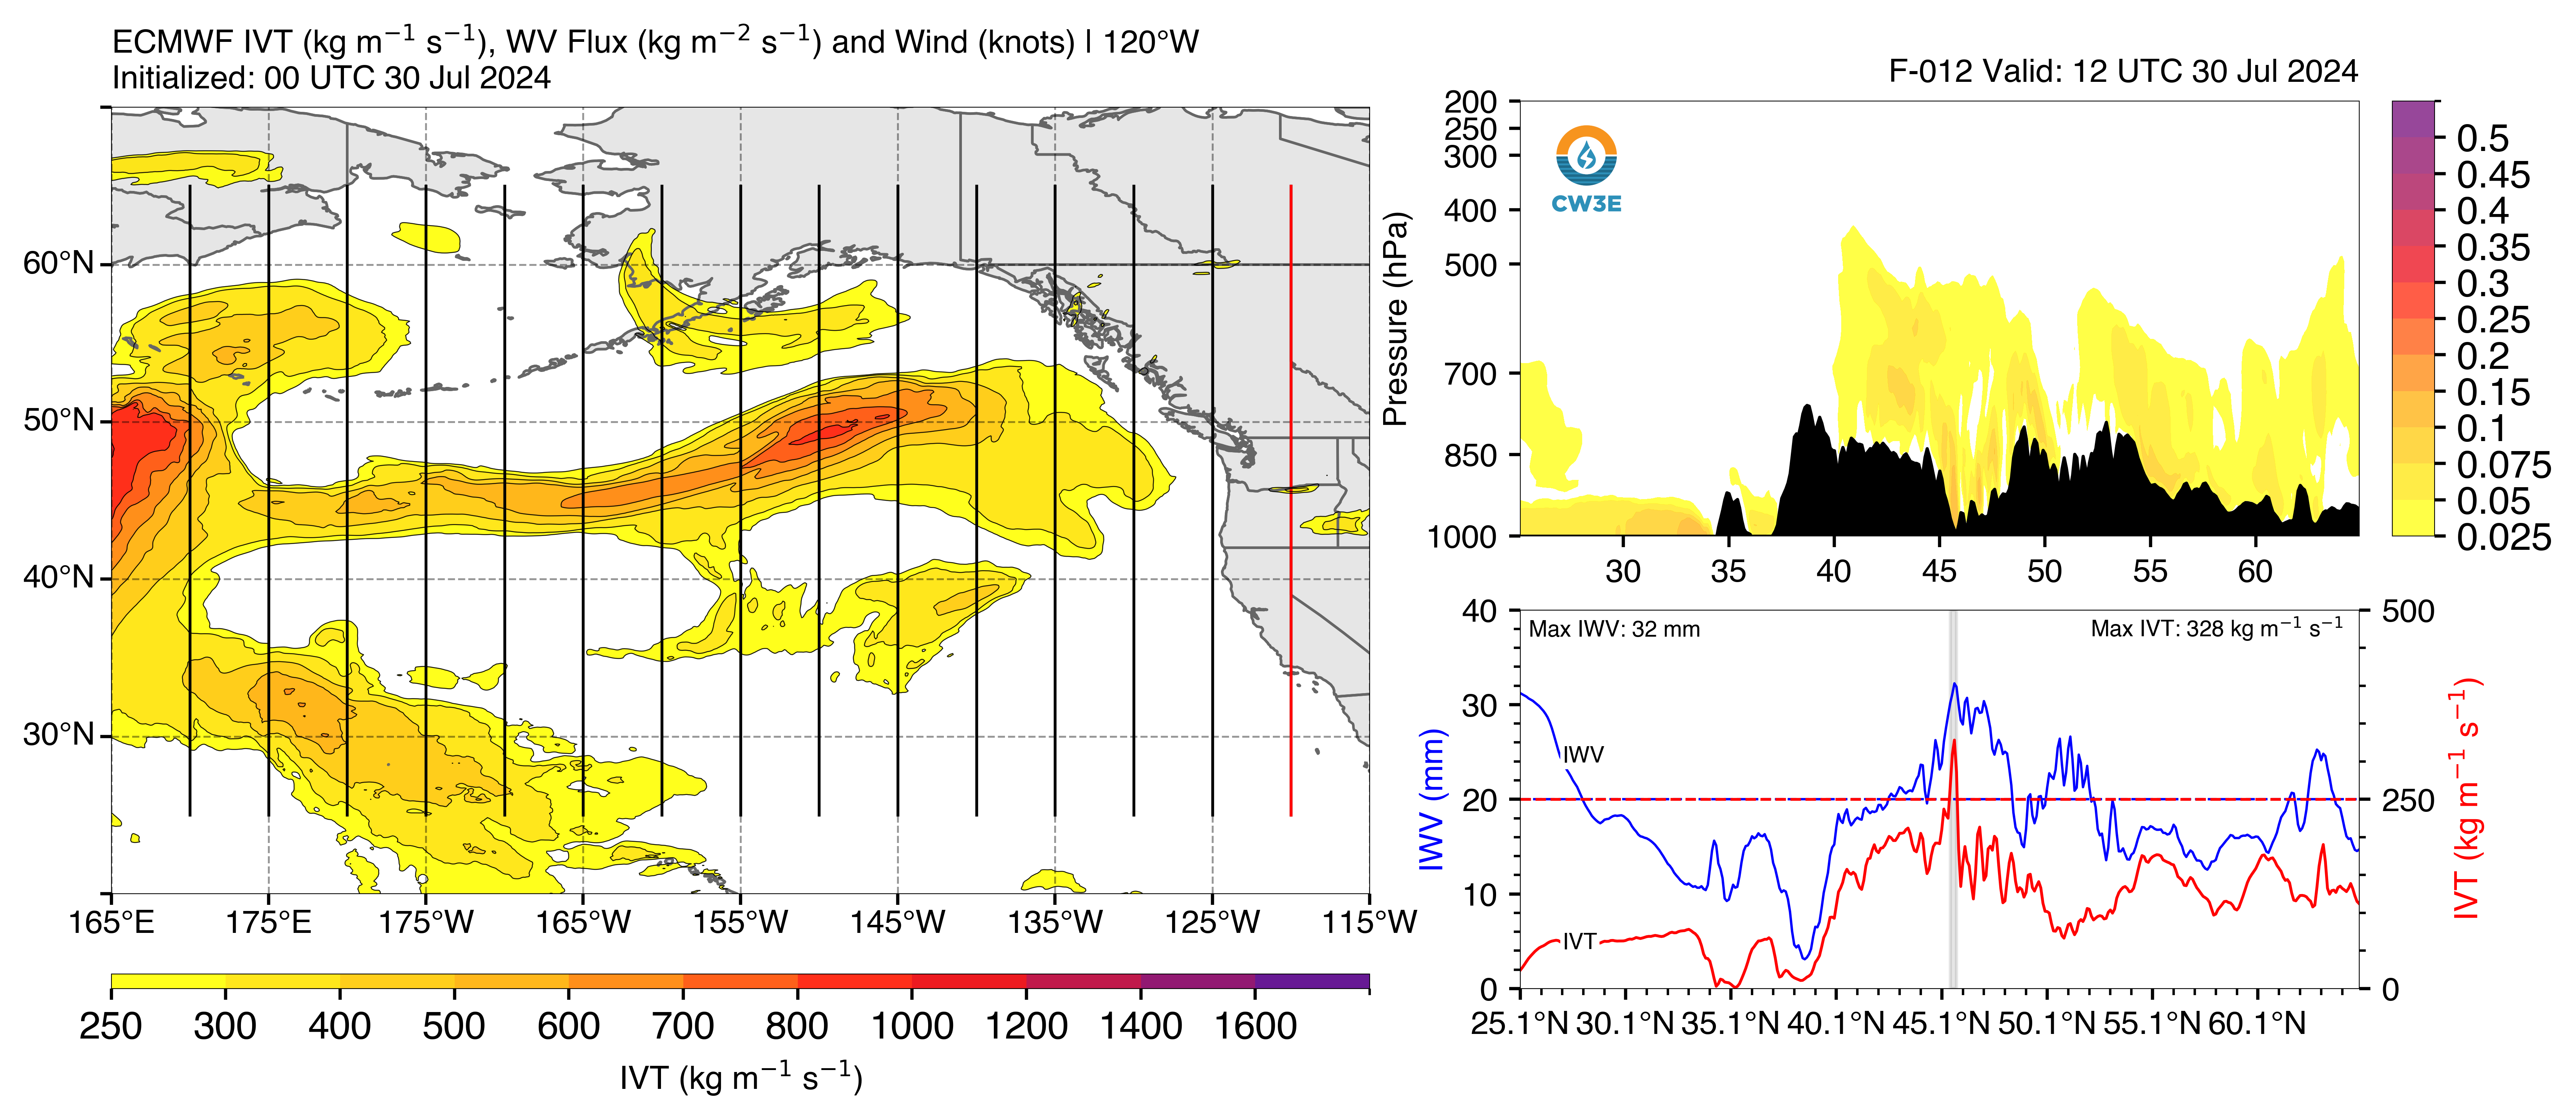

In [25]:
nrows = 3
ncols = 4

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1.5, 1, 0.05], width_ratios = [1.5, 0.1, 1, 0.05], wspace=0.06, hspace=0.3)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(13.0, 5))
fig.dpi = current_dpi
fname = 'test'
fmt = 'png'

####################
### PLOT IVT MAP ###
####################

ax = fig.add_subplot(gs[0:2, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, grid=True)
ax.set_extent(ext, datacrs)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

## filled contour (IVT)
lats = ds.latitude.values
lons = ds.longitude.values
data = ds.ivt.values
cmap, norm, bnds, cbarticks, cbarlbl = ccmaps.cmap('ivt') # get cmap from our custom function

cf = ax.contourf(lons, lats, data, transform=datacrs, levels=bnds, cmap=cmap, norm=norm, alpha=0.9)

## contour lines (IVT)
cs = ax.contour(lons, lats, data, transform=datacrs, levels=bnds, colors=['black'], linewidths=0.3, alpha=0.9, zorder=100)

## black lines where possible cross sections are
for i, line in enumerate(line_lst):
    ax.plot([line[1], line[3]], [line[0], line[2]], color='k', transform=datacrs, zorder=3)
        
## red line where current cross section is showing
ax.plot([current_line[1], current_line[3]], [current_line[0], current_line[2]], color='r', transform=datacrs, zorder=3)

ax.set_title(title + "\n" + left_title, loc="left")

## color bar
cbax = fig.add_subplot(gs[-1, 0]) # colorbar axis (first row, last column)
cbarticks = list(itertools.compress(bnds, cbarticks)) ## this labels the cbarticks based on the cmap dictionary
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom', ticks=cbarticks)
cb.set_label(cbarlbl)
cb.ax.tick_params(labelsize=12)

#####################
### CROSS SECTION ###
#####################
ax = fig.add_subplot(gs[0, 2])

## y-axis is pressure
## x-axis is latitude

# xs = np.arange(0, len(cross.latitude), 1) # how many coordinate values
xs = cross.latitude.values
x = cross['3D_lat'].values
ys = cross.pressure.values
terline = cross.sfc_pressure.values / 100. ## convert from Pa to hPa
ht_fill = ax.fill_between(xs, 1000., terline, facecolor='k', edgecolor='k', zorder=10)

# Filled contours (WV flux)
cmap, norm, bnds, cbarticks, cbarlbl = ccmaps.cmap('wvflux') # get cmap from our custom function
cf = ax.contourf(x, ys, cross.wvflux.values, levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither', zorder=-1)
plt.gca().invert_yaxis()
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Pressure (hPa)")
ax.set_ylim(1000, 200)
ax.set_yticks([1000., 850., 700., 500., 400., 300., 250., 200.])

## add freezing level
freeze_line = ax.plot(xs, cross.freezing_level, c='k')
ax.annotate('0', xy=(xs[20],cross.freezing_level[20]), xycoords='data',
            textcoords="offset points", # how to position the text
            xytext=(0,-3), # distance from text to points (x,y)
            bbox=dict(boxstyle="square,pad=0.1", fc="white", ec=None, lw=0.0),
            **style)

# # wind vectors
# dw = 6 # how often to plot vector
# ax.barbs(xs[::dw], ys[::dw], cross.u.values[::dw, ::dw]*1.94384, cross.v.values[::dw, ::dw]*1.94384, 
#          linewidth=0.25, length=3.5)

# ## apply xtick parameters (latitude labels)
# ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(xs[0], xs[-1]+1, 5)))
# ax.xaxis.set_major_formatter(LATITUDE_FORMATTER)
# ax.minorticks_on()
# ax.tick_params(axis='x', which='minor', bottom=True)
# ax.tick_params(axis='x', which='major')

## add titles
ax.set_title(right_title, loc="right")

# # Add color bar
cbax = fig.add_subplot(gs[0, -1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right', ticks=cbarticks)
cb.ax.tick_params(labelsize=12)
cb.ax.set_yticklabels(['{:g}'.format(x) for x in cbarticks]) # force cbartick labels to drop trailing zeros

## Add CW3E logo
in_ax = inset_axes(ax, width="10%", height="20%", loc='upper left')
in_ax = plot_cw3e_logo(in_ax, orientation='vertical')

###################
### TIME SERIES ###
###################
ax = fig.add_subplot(gs[1:, 2])

ax.plot(xs, cross.iwv.values, color='blue', linewidth=0.75)
ax.set_ylabel('IWV (mm)', color='blue')
ax.axhline(y=20.0, color='blue', linestyle='--', linewidth=0.75)
ax.set_xlim(xs[0], xs[-1])

## add IWV label to line
ax.annotate('IWV', xy=(xs[20],cross.iwv[20]), xycoords='data',
            textcoords="offset points", # how to position the text
            xytext=(0,-0.5), # distance from text to points (x,y)
            bbox=dict(boxstyle="square,pad=0.1", fc="white", ec=None, lw=0.0),
            **style)

## set adaptive nice yticks
iwv_max = roundPartial(cross.iwv.max().values+10, 10)
yticks = np.arange(0, iwv_max+10, 10)
ax.yaxis.set_major_locator(mticker.FixedLocator(yticks))
ax.tick_params(axis='y', which='minor', left=True)
ax.set_ylim(yticks[0], yticks[-1])

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(xs, cross.ivt.values, color='red')
ax2.set_ylabel('IVT (kg m$^{-1}$ s$^{-1}$)', color='red')
ax2.axhline(y=250.0, color='red', linestyle='--')
ax2.set_xlim(xs[0], xs[-1])

## add IVT label to line
ax2.annotate('IVT', xy=(xs[20],cross.ivt[20]), xycoords='data',
            textcoords="offset points", # how to position the text
            xytext=(0,-2), # distance from text to points (x,y)
            bbox=dict(boxstyle="square,pad=0.1", fc="white", ec=None, lw=0.0),
            **style)

## set adaptive nice yticks
ivt_max = roundPartial(cross.ivt.max().values+100, 250)
yticks = np.arange(0, ivt_max+100, 250)
ax2.yaxis.set_major_locator(mticker.FixedLocator(yticks))
ax2.minorticks_on()
ax2.tick_params(axis='y', which='minor', right=True)
ax2.set_ylim(yticks[0], yticks[-1])

## apply xtick parameters (latitude labels)
ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(xs[0], xs[-1]+1, 5)))
ax.xaxis.set_major_formatter(LATITUDE_FORMATTER)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=True)
ax.tick_params(axis='x', which='major')

## add in grey shading where IWV and IVT > thres
for i in range(len(arr)):
    ax.axvspan(xs[arr.iloc[i][0]], xs[arr.iloc[i][1]], color='grey', alpha=0.2, lw=None)
    
## add in annotation of max IWV and IVT vals
IWV_ann = 'Max IWV: {0:0.0f} mm'.format(cross.iwv.max().values)
IVT_ann = 'Max IVT: {0:0.0f} {1}'.format(cross.ivt.max().values, ivt_units)

xy = [(.01, .93), (.68, .93)]
for i, lbl in enumerate([IWV_ann, IVT_ann]):
    ax.annotate(lbl, # this is the text
                xy[i], # these are the coordinates to position the label
                xycoords='axes fraction',
                zorder=200,
                **style)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=False)
plt.show()
fig.clf()